
<font size = "5"> **Chapter 2: [Diffraction](CH2_00-Diffraction.ipynb)** </font>

<hr style="height:1px;border-top:4px solid #FF8200" />

# Kikuchi Lines

[Download](https://raw.githubusercontent.com/gduscher/MSE672-Introduction-to-TEM//main/Diffraction/CH2_10-Kikuchi_Lines.ipynb)
 
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
    https://colab.research.google.com/github/gduscher/MSE672-Introduction-to-TEM/blob/main/Diffraction/CH2_10-Kikuchi_Lines.ipynb)


part of 

<font size = "5"> **[MSE672:  Introduction to Transmission Electron Microscopy](../_MSE672_Intro_TEM.ipynb)**</font>

by Gerd Duscher, Spring 2021

Microscopy Facilities<br>
Joint Institute of Advanced Materials<br>
Materials Science & Engineering<br>
The University of Tennessee, Knoxville

Background and methods to analysis and quantification of data acquired with transmission electron microscopes


## Load relevant python packages
### Check Installed Packages

In [1]:
import sys
from pkg_resources import get_distribution, DistributionNotFound

def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = get_distribution(package_name).version
    except (DistributionNotFound, ImportError) as err:
        version = '-1'
    return version

# Colab setup ------------------
if 'google.colab' in sys.modules:
    !pip install pyTEMlib -q
# pyTEMlib setup ------------------
else:
    if test_package('pyTEMlib') < '0.2021.2.1':
        print('installing pyTEMlib')
        !{sys.executable} -m pip install  --upgrade pyTEMlib -q
# ------------------------------
print('done')

installing pyTEMlib
done


### Load the plotting and figure packages
Import the python packages that we will use:

Beside the basic numerical (numpy) and plotting (pylab of matplotlib) libraries,
some libraries from the book
* kinematic scattering library.

In [1]:
# import matplotlib and numpy
#                       use "inline" instead of "notebook" for non-interactive plots
import sys
if 'google.colab' in sys.modules:
    %pylab --no-import-all inline
else:
    %pylab --no-import-all notebook
    
# 3D plotting package used
from mpl_toolkits.mplot3d import Axes3D # 3D plotting 

# additional package 
import itertools 
import scipy.constants as const

# Import libraries from the pyTEMlib
import pyTEMlib
import pyTEMlib.KinsCat as ks         # Kinematic sCattering Library
                             # Atomic form factors from Kirklands book
__notebook_version__ = '2021.02.17'

print('pyTEM version: ', pyTEMlib.__version__)
print('notebook version: ', __notebook_version__)

Populating the interactive namespace from numpy and matplotlib
Using KinsCat library version  0.5  by G.Duscher
spglib not installed; Symmetry functions of spglib disabled
pyTEM version:  0.2021.02.17
notebook version:  2021.02.17


C:\Users\gduscher\Anaconda3\lib\site-packages\pyUSID\viz\__init__.py:16: FutureWarning: Please use sidpy.viz.plot_utils instead of pyUSID.viz.plot_utils. pyUSID.plot_utils will be removed in a future release of pyUSID
  warn('Please use sidpy.viz.plot_utils instead of pyUSID.viz.plot_utils. '


## Kikuchi Pattern

An electron can be scattered elastically into the Bragg angle, or it can be scattered inelastically

The inelastically scattered electrons are emitted in all directions.

These inelastically scattered electrons are then diffracted at the crystal planes according to Bragg's law. 


![Kossel cone](images/Kikuchi-small.png)

This results in a cone, where the Bragg diffraction is allowed; this cone is called Kossel cone. Because the electrons are predominantly scattered in the direction of the incident beam, this Bragg diffraction will take some intensity out of the original beam (dark line: deficit line in  the figure )and transfer it to a different angle (bright band: excess line in the figure. Inside this bands is some intensity which depends on the dynamic scattering.

The most important feature of the Kikuchi band is that the Kossel cones are fixed to the crystal and allow easy navigation in reciprocal space, because nothing changes with the angle (the excitation error and thickness changes for SAD patterns). 
A common example if you want to tilt out of a zone axis, but you also want to keep an interface edge on; you just follow the Kikuchi band of the interface plane.

Note: 
>the Kikuchi bands are bent, they just appear straight, because the Ewald sphere is so large. 

Note: 
>According to the explanation above, no Kikuchi lines should be visible if we are in a low order zone axis. This is not true because of the channeling effect and dynamic scattering, but these effects do not change anything about the location, where we expect the Kikuchi lines.


## Constructing Kikuchi Maps
### Define  crystal


In [2]:
### Please choose another crystal like: Silicon, Aluminium, GaAs , ZnO
tags = ks.structure_by_name('silicon')

### Plot the unit cell
Just to be sure the crystal structure is right

<IPython.core.display.Javascript object>


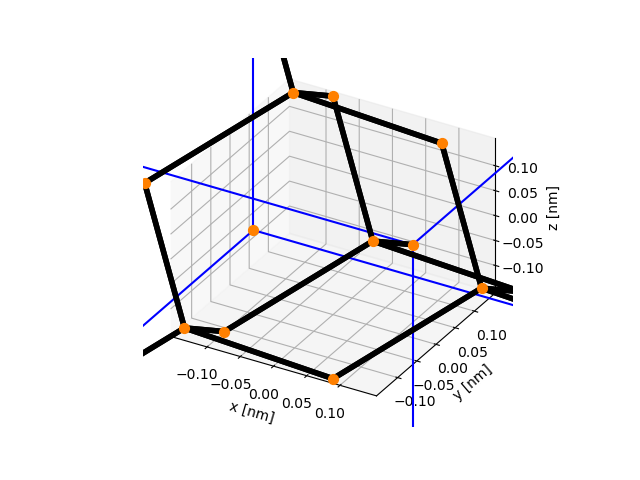

In [3]:
ks.plot_unitcell(tags)

### Parameters for Diffraction Calculation

Please note that we are using a rather small number of reflections: the maximum number of Miller indices 
> maximum hkl is 1

In [4]:
tags['acceleration_voltage_V'] = 20.0 *1000.0 #V

tags['convergence_angle_mrad'] = 0

tags['zone_hkl'] = np.array([0,1,1])  # incident neares zone axis: defines Laue Zones!!!!
tags['mistilt']  = np.array([0,0,0])  # mistilt in degrees

tags['Sg_max'] = .5 # 1/nm  maximum allowed excitation error ; This parameter is related to the thickness
tags['hkl_max'] = 1   # Highest evaluated Miller indices


###  Calculation

In [5]:
ks.kinematic_scattering(tags, False)


### Plot Selected Area Electron Diffraction Pattern

<IPython.core.display.Javascript object>


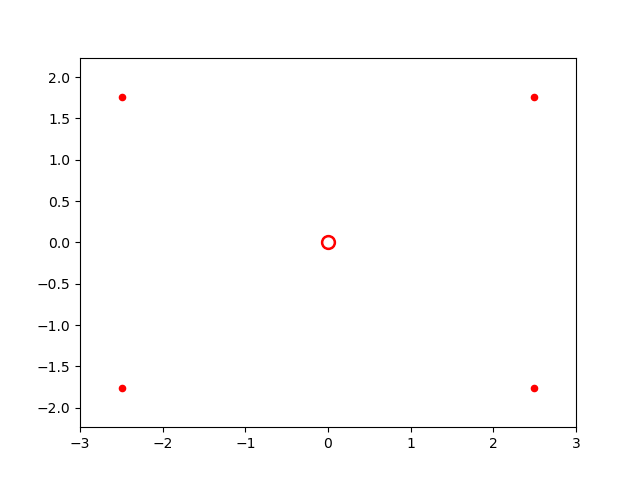

In [6]:
#####################
# Plot ZOLZ SAED Pattern #
#####################

# Get information from dictionary
# Get information from dictionary

#We plot only the allowed diffraction spots
points = tags['allowed']['g']
# we sort them by order of Laue zone
ZOLZ = tags['allowed']['ZOLZ']

# Plot
fig = plt.figure()
ax = fig.add_subplot(111)
# We plot the x,y axis only; the z -direction is set to zero - this is our projection
ax.scatter(points[ZOLZ,0], points[ZOLZ,1], c='red', s=20)

# zero spot plotting
ax.scatter(0,0, c='red', s=100)
ax.scatter(0,0, c='white', s=40)

ax.axis('equal')
FOV = 3
plt.ylim(-FOV,FOV); plt.xlim(-FOV,FOV);

## Kikuchi Line Construction
The Kikuchi lines are the Bisections of lines from the center spot to the Bragg spots.

The line equation for a bisection of a line between two points $(A(x_A,y_A), B(x_B,y_B))$ is  given by the formula:

$y=-\frac{x_A-x_B}{y_A-y_B}x+\frac{x_A^2-x_B^2+y_A^2-y_B^2}{2 \cdot(y_A-y_B)}$

If $y_A = y_B$, then x is constant at $x= \frac{1}{2} (x_A+x_B)$

In our case  point $B$ is $(0,0)$ and so above equation is:

$y=-\frac{x_A}{y_A}x+\frac{x_A^2+y_A^2}{2 y_A}$ 

If $y_A$ is zero, the line is horizontal and $ x$ is constant at $x= \frac{1}{2} x_A$.

([-3, 3], [6.889047180788267, -1.5962341934503046])


<IPython.core.display.Javascript object>


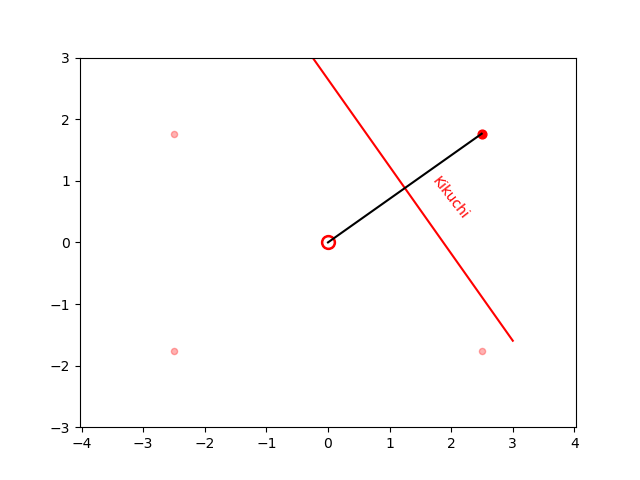

In [7]:
pointsZ = points[ZOLZ]

g = pointsZ[1,0:2]

x_A, y_A = g


slope = -x_A/y_A
y_0 = (x_A**2+ y_A**2)/(2*y_A)

# Starting point of Kikuchi Line
x1 = -FOV
y1 = y_0+slope*x1
# End point of Kikuchi Line
x2= FOV
y2 = y_0+slope*x2


print(([x1,x2],[y1,y2]))
# Plot
fig = plt.figure()
ax = fig.add_subplot(111)
# We plot the x,y axis only; the z -direction is set to zero - this is our projection
ax.scatter(points[ZOLZ,0], points[ZOLZ,1], c='red', s=20 , alpha = .3)
ax.scatter(g[0], g[1], c='red', s=40)
# Draw kikuchi
ax.plot([x1,x2],[y1,y2],c='r')
ax.text(g[0]/2+0.4,g[1]/2-0.5, 'Kikuchi',color ='r', rotation=-52)
ax.plot([0,g[0]],[0,g[1]],c='black')

# zero spot plotting
ax.scatter(0,0, c='red', s=100)
ax.scatter(0,0, c='white', s=40)

ax.axis('equal')
FOV = 3
plt.ylim(-FOV,FOV); plt.xlim(-FOV,FOV); plt.show()

Assume we have an SAD pattern, from experiment or simulation. Draw a line from the center to each ZOLZ diffraction spot and draw a line perpendicular to the first line at half the distance. We name the line with the same Miller indices as the spot. The distance between two pair of lines is then again $|\vec{g}|$ of the original spots. 

If we know in which direction the next low order zone axis is and how far we have to tilt to get to it, we can draw that pole too.

-2.4950559699326007 1.7642709957793206
([-3, 3], [-1.5962341934503046, 6.889047180788267])


<IPython.core.display.Javascript object>


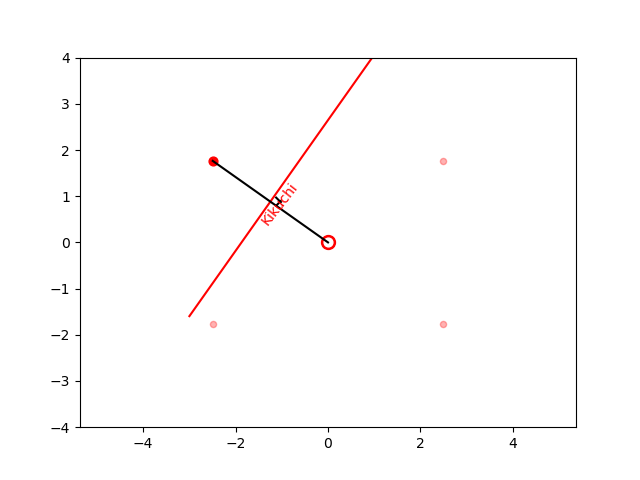

In [8]:
pointsZ = points[ZOLZ]

g = pointsZ[0,0:2]

x_A, y_A = g
print(x_A, y_A)
slope = -x_A/y_A
y_0 = (x_A**2+ y_A**2)/(2*y_A)

x1 = -FOV
y1 = y_0+slope*x1

x2= FOV
y2 = y_0+slope*x2


print(([x1,x2],[y1,y2]))
# Plot
fig = plt.figure()
ax = fig.add_subplot(111)
# We plot the x,y axis only; the z -direction is set to zero - this is our projection
ax.scatter(points[ZOLZ,0], points[ZOLZ,1], c='red', s=20 , alpha = .3)
ax.scatter(g[0], g[1], c='red', s=40)
ax.plot([x1,x2],[y1,y2],c='r')
ax.text(x1/2,g[1]/2-.5, 'Kikuchi',color ='r', rotation=52)
ax.plot([0,g[0]],[0,g[1]],c='black')

# Make right angle symbol
ax.plot([g[0]/2*.9,g[0]/2*.9+.1],[g[1]/2*.9,g[1]/2*.9+.1],c='black') 
ax.plot([g[0]/2*.9,g[0]/2*.9+.1],[g[1]/2*1.1,g[1]/2*1.1-.1],c='black') 

# zero spot plotting
ax.scatter(0,0, c='red', s=100)
ax.scatter(0,0, c='white', s=40)

ax.axis('equal')
FOV = 4
plt.ylim(-FOV,FOV); plt.xlim(-FOV,FOV); plt.show()

### Plotting of Kikuchi Pattern

<IPython.core.display.Javascript object>


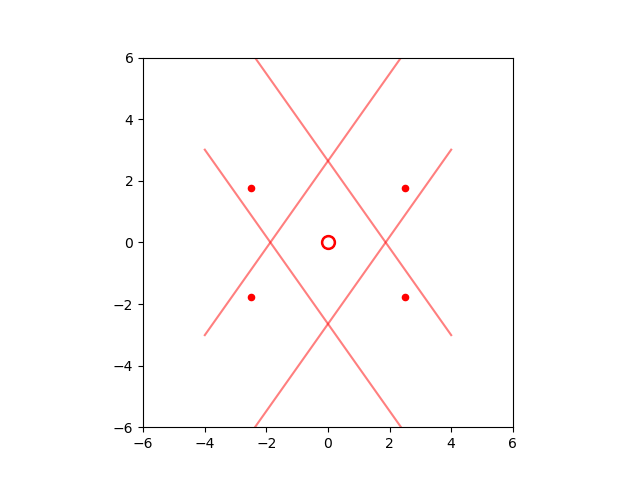

In [9]:
pointsZ = points[ZOLZ]

g = pointsZ[:,0:2]

FOV = 4
slope = -g[:,0]/g[:,1]
y_0 = (g[:,0]**2+ g[:,1]**2)/(2*g[:,1])

x1 = -FOV
y1 = y_0+slope*x1

x2= FOV
y2 = y_0+slope*x2


# Plot
fig = plt.figure()
ax = fig.add_subplot(111)
# We plot the x,y axis only; the z -direction is set to zero - this is our projection
ax.scatter(points[ZOLZ,0], points[ZOLZ,1], c='red', s=20 )
ax.plot([x1,x2],[y1,y2],c='r', alpha = 0.5)




# zero spot plotting
ax.scatter(0,0, c='red', s=100)
ax.scatter(0,0, c='white', s=40)

ax.set_aspect('equal')
FOV = 6
plt.ylim(-FOV,FOV); plt.xlim(-FOV,FOV); plt.show()

## Plotting of Whole Kikuchi Pattern
with a few more Bragg peaks, so please increase **hkl_max** and see what happens!


<IPython.core.display.Javascript object>


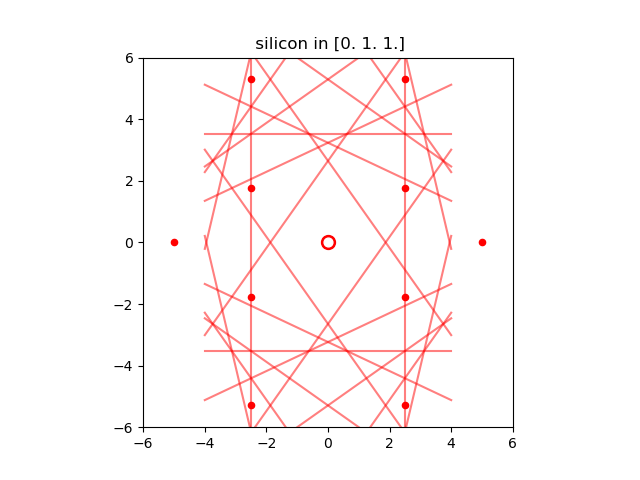

<ipython-input-10-f8edc867d269>:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


In [10]:
tags['hkl_max'] = 4
ks.kinematic_scattering(tags, False)
#We plot only the allowed diffraction spots
points = tags['allowed']['g']
# we sort them by order of Laue zone
ZOLZ = tags['allowed']['ZOLZ']

pointsZ = points[ZOLZ]

g = pointsZ[:,0:2]

FOV = 4
slope = -g[:,0]/g[:,1]
y_0 = (g[:,0]**2+ g[:,1]**2)/(2*g[:,1])

x1 = -FOV
y1 = y_0+slope*x1
x2= FOV
y2 = y_0+slope*x2

# Plot
fig = plt.figure()
plt.title(f" {tags['crystal_name']} in {tags['zone']}")
ax = fig.add_subplot(111)
# We plot the x,y axis only; the z -direction is set to zero - this is our projection
ax.scatter(points[ZOLZ,0], points[ZOLZ,1], c='red', s=20 )
ax.plot([x1,x2],[y1,y2],c='r', alpha = 0.5)


# zero spot plotting
ax.scatter(0,0, c='red', s=100)
ax.scatter(0,0, c='white', s=40)

ax.set_aspect('equal')
FOV = 6
plt.ylim(-FOV,FOV); plt.xlim(-FOV,FOV); plt.show()

## Plotting of Whole Kikuchi Pattern with KinsCat Library

tags['mistilt'] = [0., 0., 0.]


<IPython.core.display.Javascript object>


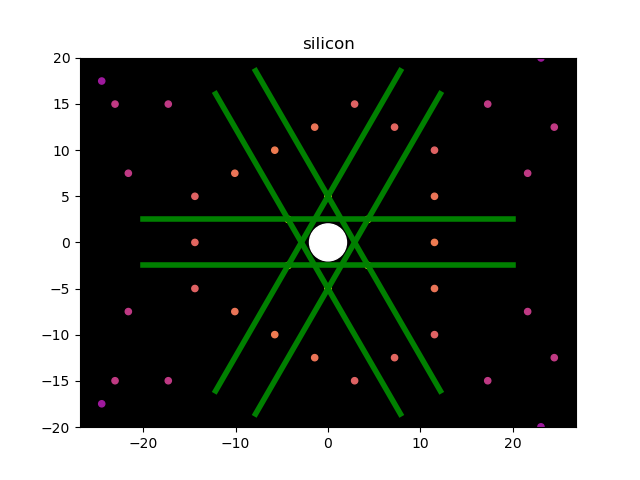

In [48]:
tags = ks.structure_by_name('silicon')
tags['acceleration_voltage_V'] = 20.0 *1000.0 #V

tags['convergence_angle_mrad'] = 0
tags['Sg_max'] = .3 # 1/nm  maximum allowed excitation error ; This parameter is related to the thickness
tags['hkl_max'] = 25   # Highest evaluated Miller indices
tags['zone_hkl'] = np.array([1,1,1])  
ks.kinematic_scattering(tags, False)
tags['plot FOV'] = 20
ks.plotKikuchi(tags)

In [12]:
## Mistilt  in Kikuchi Pattern



In [1]:
from pyTEMlib import kinematic_scattering as ks2
from pyTEMlib import diffraction_plot as diff_plot

# Crystal unit cell defintion 
crystal = 'Aluminum'
tags = ks.structure_by_name(crystal)

# Experimental parameters needed
tags['acceleration_voltage_V'] = 200.*1000.#V
tags['convergence_angle_mrad'] = 10

tags['hkl_max'] = 25   # highest evaluated Miller indices
tags['thickness'] = 20 ## sample thickness (in nm) causes ring broadening

# Additional for SAED
tags['zone_hkl'] = np.array([1,1,0])
tags['Sg_max'] = .4 # 1/nm  maximum allowed excitation error
tags['mistilt alpha degree'] = 0.8 #-45#-35-0.28-1+2.42
tags['mistilt beta degree'] = 0.

tags['mistilt'] = [.0,0.0,0]
tags['thickness'] = 50
ks2.kinematic_scattering(tags,verbose=False)
tags['plot FOV'] = 30

##################
## OUTPUT OPTIONS
##################
diff_plot.plotSAED_parameter(tags, gray=False)
tags['plot Kikuchi'] = True
tags['color Kikuchi'] = 'navy'
tags['background'] = 'gray'

tags['label size'] = 12
tags['plot shift x'] = 0
tags['plot shift y'] = 0
tags['image gamma'] = 2

tags['label color'] = 'skyblue'
tags['color zero'] = 'white'

############
## OUTPUT
############

diff_plot.plot_diffraction_pattern(tags, grey=False)

ImportError: cannot import name 'kinematic_scattering' from 'pyTEMlib' (C:\Users\gduscher\Anaconda3\lib\site-packages\pyTEMlib\__init__.py)

<IPython.core.display.Javascript object>


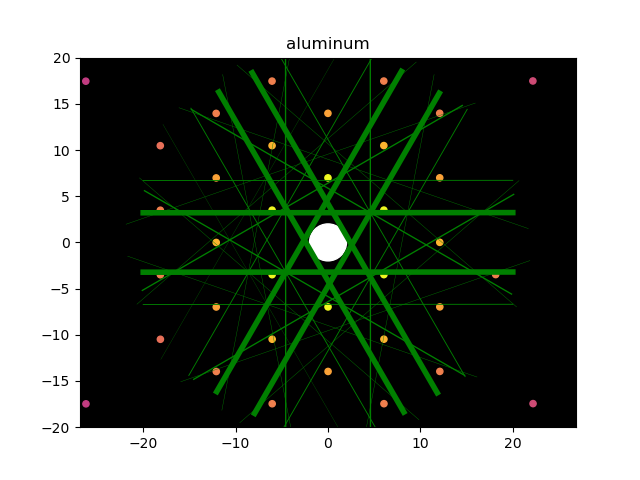

In [68]:
tags['mistilt'] = [0, .3, .2]
tags['zone_hkl'] = np.array([1,1,0])  
tags['Sg_max'] = .5 # 1/nm  maximum allowed excitation error ; This parameter is related to the thickness
tags['hkl_max'] = 25   # Highest evaluated Miller indices
tags['zone_hkl'] = np.array([1,1,1])  
ks.kinematic_scattering(tags, False)
tags['mistilt alpha degree'] = 0.2 #-45#-35-0.28-1+2.42
tags['mistilt beta degree'] = 0.
tags['plot FOV'] = 20
ks.plotKikuchi(tags)
plt.gca().scatter(0,0, color='red')

## Kikuchi Maps

Extremly helpfull for tilting a sample to a different zone axis are maps of Kikuchi pattern as the one below.

![Diamond Kikuchi Map](images/Diamondkikuchi.png)


If you are in a specific zone axis, which we identify by its symmetry (like the SAED 

## Kikuchi Lines and Excitation Error

Since the Kikuchi lines are rigidly attached to the crystal, we can use them to measure the excitation error. The diffraction geometry is shown in the figure above.  If $\vec{s}_g = 0$ the deficient line of a Kikuchi band (a pole) lays in the origin. If we tilt the sample so that the whole band shifts 
to the bright line, then the excitation error is positive. The angle $\eta$ (which is equal to $\epsilon$) is related to the excitation error by simple trigonometry:
\begin{eqnarray}
\eta &=& \frac{x}{L}= \frac{x \lambda}{R d}\\
\epsilon &=& \frac{s}{g}\\
s &=& \epsilon = \frac{x}{L}g = \frac{x}{Ld}\\
\frac{R}{L}&=& 2\theta_B=\frac{\lambda}{d}\\
s&=& \frac{xL}{d}=\frac{x}{d}\cdot\frac{\lambda}{Rd}\\
s&=& \frac{x\lambda}{R d^2}=\frac{x}{R}\lambda g^2
\end{eqnarray}

<IPython.core.display.Javascript object>


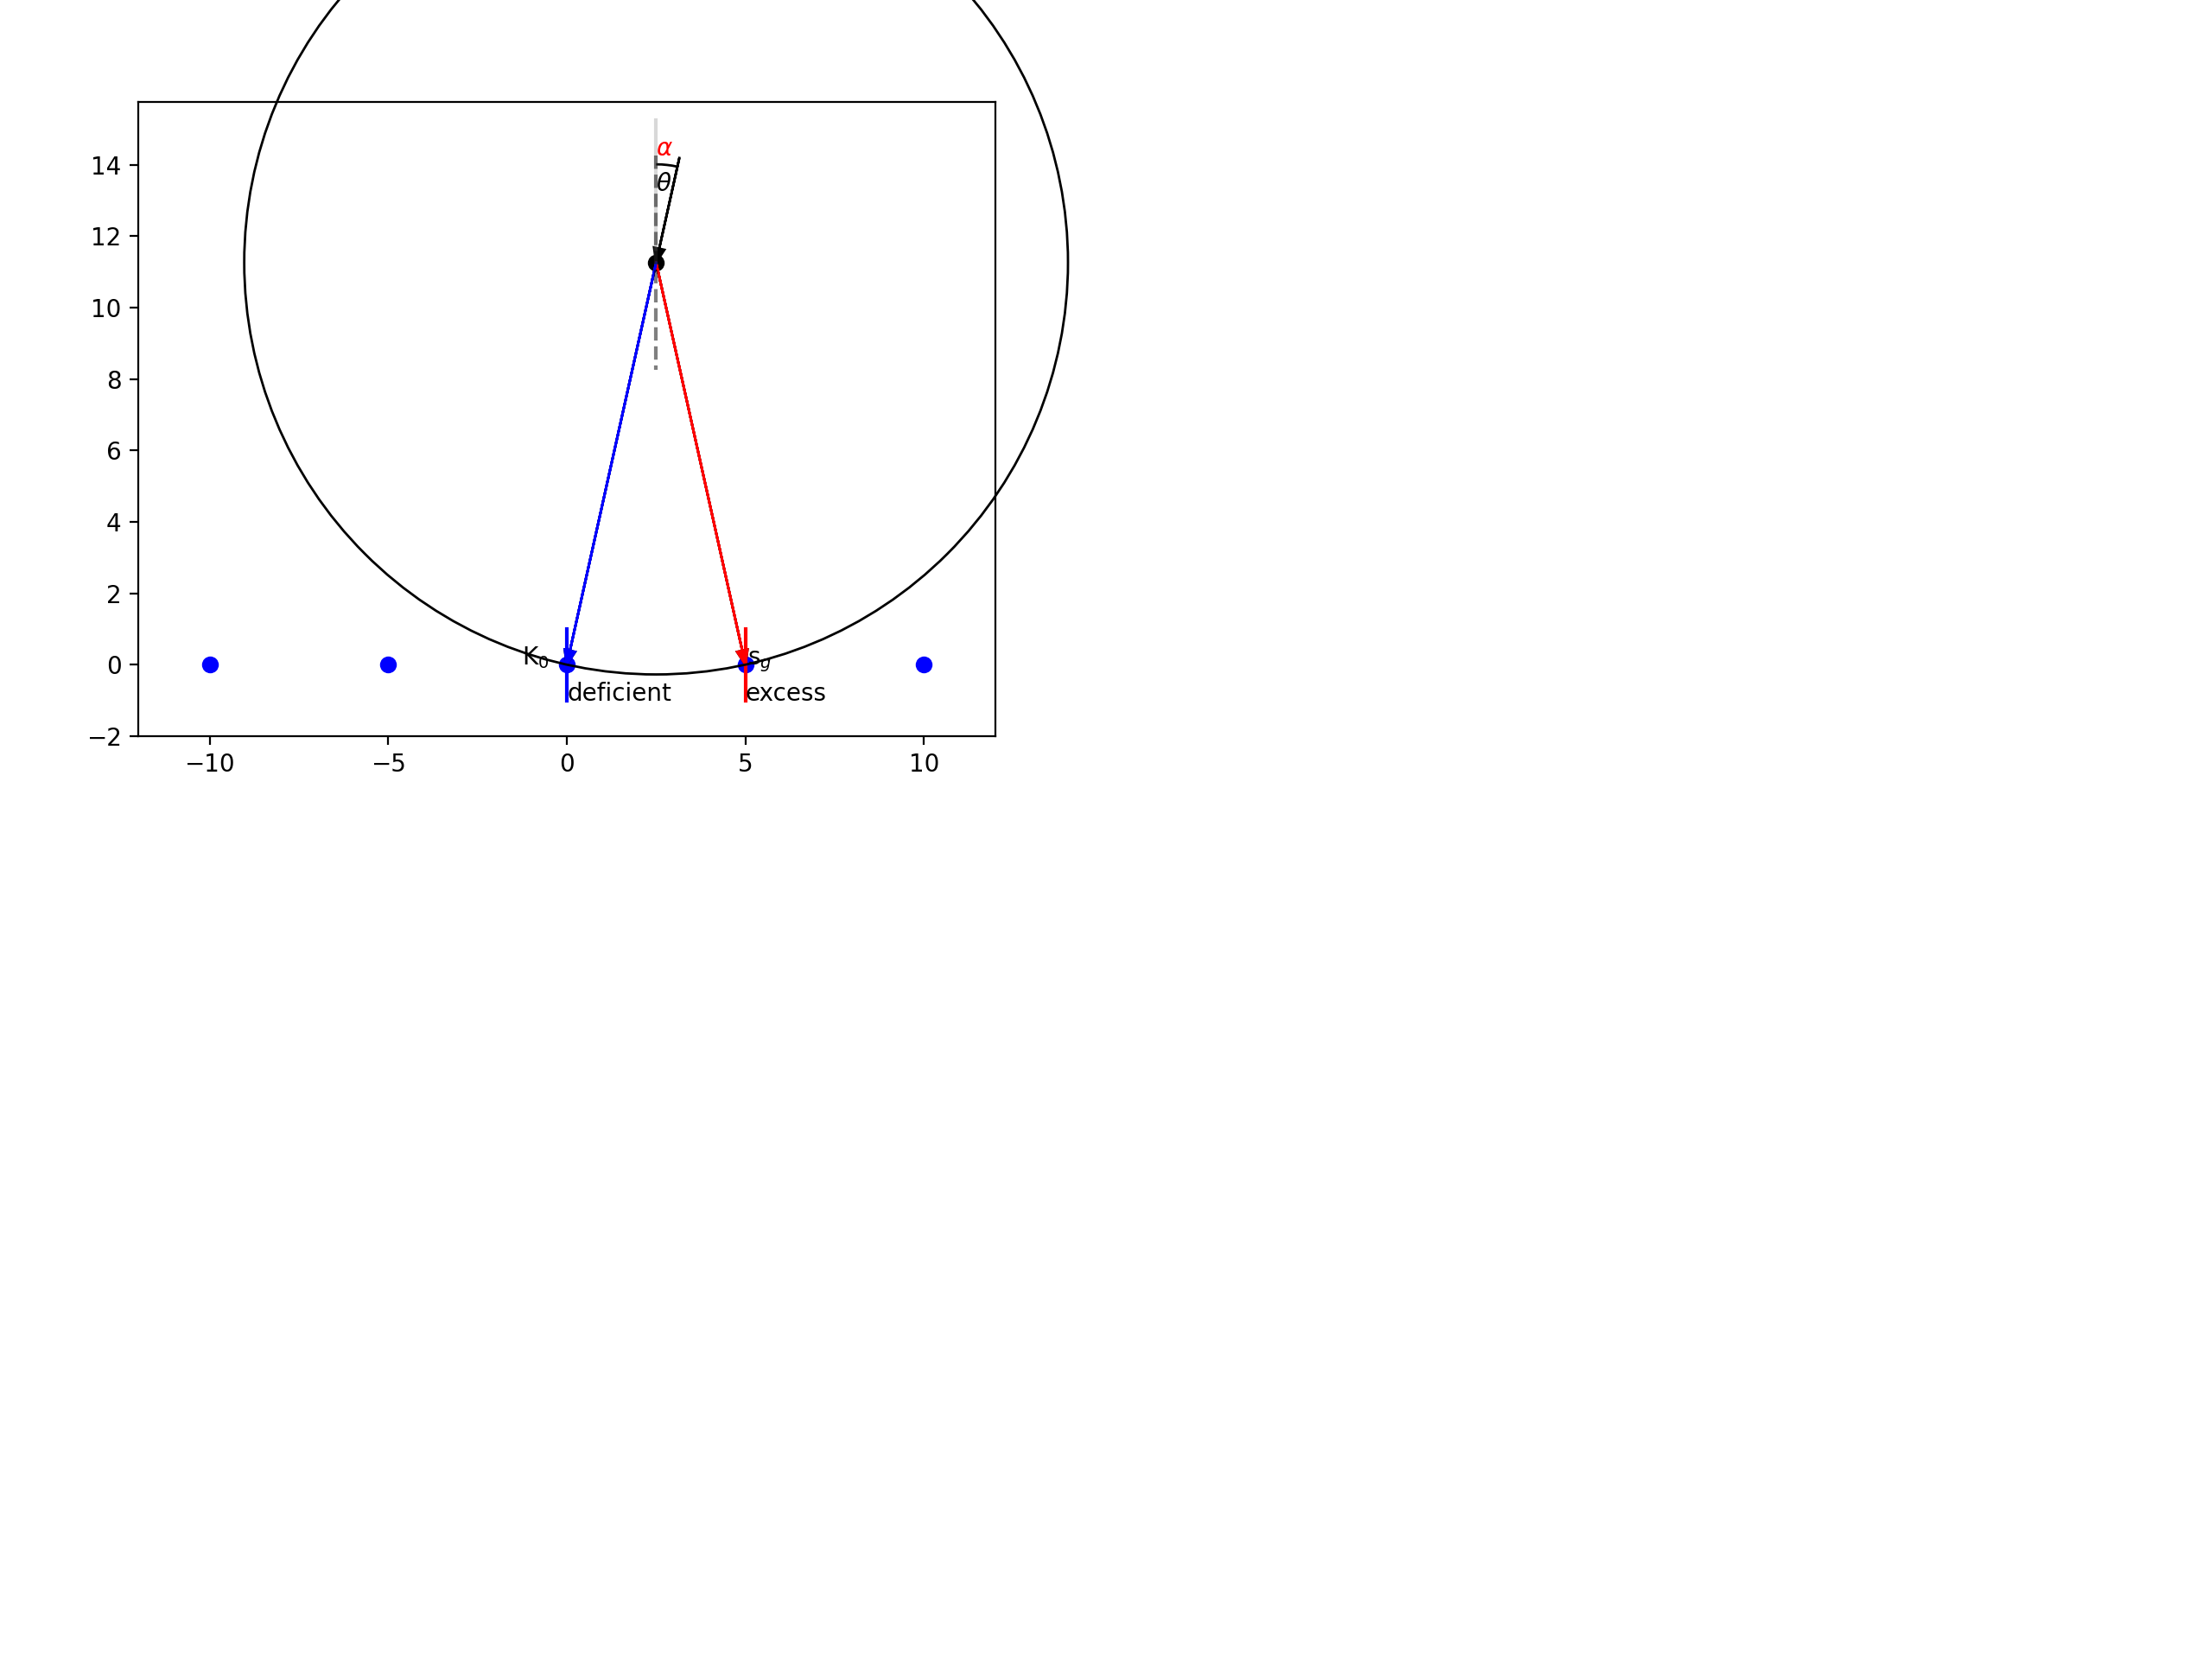

In [13]:
from matplotlib import patches

def deficient_kikuchi_line(s_g = 0., color_B='black'):

    k_len= 1/ks.get_wavelength(200)
    d = .2 # lattice parameter in nm
    
    g = np.linspace(-2,2,5)* 1/d
    g_d = np.array([1/d, 0])
    
    # recirocal lattice
    plt.scatter(g, [0]*5, color='blue')
   
    alpha = -np.arctan(s_g/g_d[0])
    theta = -np.arcsin(g_d[0]/2/k_len)
    
    k_0 = np.array([-np.sin(theta-alpha)*k_len, np.cos(theta-alpha)*k_len])
    k_d = np.array([-np.sin(-theta-alpha)*k_len, np.cos(-theta-alpha)*k_len])
    k_i = np.array([-np.sin(theta-alpha)*3, np.cos(theta-alpha)*3])
    k_i_t = np.array([-np.sin(-alpha)*3, np.cos(-alpha)*3])
    
    kk_e = np.array([-np.sin(-theta)* k_len,np.cos(-theta) * k_len])
    kk_d = np.array([-np.sin(theta)* k_len,np.cos(theta) * k_len])
    
    # Ewald Sphere
    ewald_sphere = patches.Circle((k_0[0], k_0[1]), radius=np.linalg.norm(k_0), clip_on=False, zorder=10, linewidth=1,
                        edgecolor=color_B, fill=False)
    plt.gca().add_artist(ewald_sphere)    
    
    # K_0
    plt.plot([k_0[0], k_0[0]], [k_0[1], k_0[1]+4], color='gray', linestyle='-', alpha=0.3)
    
    plt.gca().arrow(k_0[0]+k_i[0], k_0[1]+k_i[1], -k_i[0], -k_i[1], head_width=0.3, head_length=0.4, fc=color_B, 
             ec=color_B, length_includes_head=True)
    plt.plot([k_0[0]+k_i_t[0], k_0[0]-k_i_t[0]], [k_0[1]+k_i_t[1], k_0[1]-k_i_t[1]], color='black', linestyle='--', alpha=0.5)
    plt.scatter(k_0[0],k_0[1], color='black')
    plt.gca().arrow(k_0[0], k_0[1], -k_0[0], -k_0[1], head_width=0.3, head_length=0.4, fc=color_B, 
             ec=color_B, length_includes_head=True)
    plt.gca().annotate("K$_0$",  xytext=(-k_0[0]/2, 0), xy=(k_0[0]/2, 0))
    
    plt.gca().arrow(k_0[0], k_0[1], -k_d[0], -k_d[1], head_width=0.3, head_length=0.4, fc=color_B, 
             ec=color_B, length_includes_head=True)
    
    # K_e exces line
    plt.gca().arrow(k_0[0], k_0[1], -kk_e[0], -kk_e[1], head_width=0.3, head_length=0.4, fc='red', 
             ec='red', length_includes_head=True)
    plt.gca().annotate("excess",  xytext=( k_0[0]-kk_e[0], -1), xy=(-kk_e[0]+k_0[0], 0))
    plt.plot([k_0[0]-kk_e[0], k_0[0]-kk_e[0]], [-1,1], color='red')
    
    # k_d deficient line
    plt.gca().arrow(k_0[0], k_0[1], -kk_d[0], -kk_d[1], head_width=0.3, head_length=0.4, fc='blue', 
             ec='blue', length_includes_head=True)
    plt.plot([k_0[0]-kk_d[0], k_0[0]-kk_d[0]], [-1,1], color='blue')
    plt.gca().annotate("deficient",  xytext=(k_0[0]-kk_d[0], -1), xy=(k_0[0]-kk_d[0], 0))
    
    # s_g excitation Error of HOLZ reflection
    plt.gca().arrow(g_d[0], g_d[1], 0, s_g, head_width=0.3, head_length=0.4, fc='k', 
             ec='k', length_includes_head=True)
    plt.gca().annotate("s$_g$",  xytext=(g_d[0]*1.01, g_d[1]+s_g/3), xy=(g_d[0]*1.01, g_d[1]+s_g/3))

    theta = np.degrees(theta)
    alpha = np.degrees(alpha)
    
    bragg_angle = patches.Arc((k_0[0],k_0[1]), width=5.5, height=5.5, 
                              theta1=90+theta-alpha, theta2=90-alpha, fc='black', ec='black')
    if alpha>0:
        deviation_angle = patches.Arc((k_0[0],k_0[1]), width=6, height=6, 
                              theta1=90-alpha, theta2=90, fc='black', ec='red')
    else:
        deviation_angle = patches.Arc((k_0[0],k_0[1]), width=6, height=6, 
                      theta1=90, theta2=90-alpha, fc='black', ec='red')

    plt.gca().annotate(r"$\theta$",  xytext=(k_0[0]+k_i_t[0]/1.3, k_0[1]+2), xy=(k_0[0]+k_i_t[0], k_0[1]+2))
    plt.gca().annotate(r"$\alpha$",  xytext=(k_0[0]+k_i_t[0]/1.3, k_0[1]+3), xy=(k_0[0]+k_i_t[0], k_0[1]+3), color='red')
    plt.gca().add_patch(bragg_angle)
    plt.gca().add_patch(deviation_angle)  
    
    plt.xlim(-12,12)
    plt.ylim(-2,k_0[1]*1.4)
    plt.gca().set_aspect('equal')
    
plt.figure()
deficient_kikuchi_line(s_g= 0.)

Principle of excitation error determination. You can use this to obtain exact Bragg (s_g=0) conditions  in your diffraction pattern.

## Conclusion
The Kikuchi lines are directly related to the Bragg reflections and therefore show the same symmetry as the diffraction pattern.


## Navigation

- <font size = "3">  **Back: [Unit Cel Determination](CH2_09-Unit_Cell.ipynb)** </font>
- <font size = "3">  **Next: [HOLZ Lines](CH2_11-HOLZ_Lines.ipynb)** </font>
- <font size = "3">  **Chapter 2: [Diffraction](CH2_00-Diffraction.ipynb)** </font>
- <font size = "3">  **List of Content: [Front](../_MSE672_Intro_TEM.ipynb)** </font>